# Проект "Сборный проект-2"

## Общая информация

### Исходные данные

 Файл logs.csv. 
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная;


### Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

## Цель проекта:
* Проанализировать поведение покупателей
* Исследовать результаты A/A/B-эксперимента


## План работы:
* Предобработка данных
* Исследование данных
* Изучение воронки событий
* Анализ результатов эксперимента
* Вывод

## Предобработка данных

In [1]:
# Импортируем библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt# Проект "Принятие решений в бизнесе"

In [2]:
try:
    logs = pd.read_csv('C:/Users/user/Desktop/Практикум/сборный проект 2/logs_exp.csv', sep="\t")
except:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep = '\t') #  файл данных пользователей мобильного приложения
    

In [3]:
logs.info()
logs.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
logs.columns = logs.columns.str.lower()

In [5]:
logs = logs.rename(columns = {'expid':'group','deviceidhash':'user_id' })

In [6]:
logs.head(5)

,eventname,user_id,eventtimestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [7]:
#  Проверяем исходники на явные дубликаты
logs.duplicated().sum()

413

In [8]:
#удаляем дубликаты
logs = logs.drop_duplicates()

In [9]:
# добавляем столбцы с датой+время и датой
logs['date_time'] = pd.to_datetime(logs['eventtimestamp'], unit='s')
logs['date'] = pd.to_datetime(logs['date_time']).dt.date


In [10]:
# Проверяем есть ли пользователи попавшие в несколько групп теста
groupA = logs.query('group == 246')['user_id']
groupB = logs.query('group == 247')['user_id']
groupC = logs.query('group == 248')['user_id']
set(groupA) & set(groupB)& set(groupC)

set()

* В данных отсутствуют явные дубликаты и пропуски. Группы теста имеют уникальных пользователей. Данные приведены в соответствующие форматы. Качество данных позволяет проводит их дальнейшее исследование.

## Исследование данных

In [13]:
# Смотрим среденее количество событий на одного пользователя
round(logs.groupby('user_id', as_index=False).agg({'eventname': 'count'})['eventname'].mean(),1)

32.3

In [14]:
# определяем минимальную и максимальную дату активности пользователей
min_date_user = logs['date'].min()
max_date_user = logs['date'].max()
print('Начало теста: ',min_date_user)
print('Конец теста: ',max_date_user)

Начало теста:  2019-07-25
Конец теста:  2019-08-07


In [15]:
# смотрим распеределение событий за время эксперимента
logs.groupby('date', as_index=False).agg({'eventname': 'count'})

,date,eventname
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


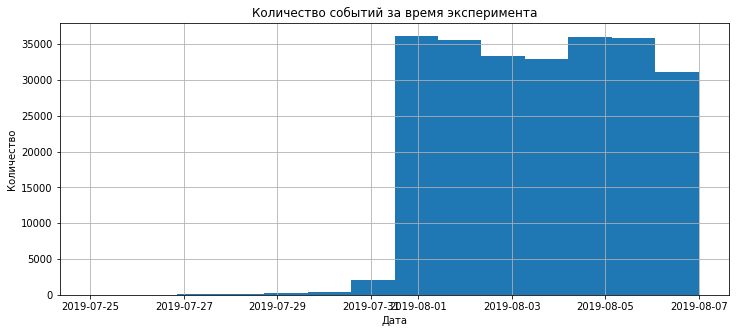

In [16]:
plt.figure(figsize=(12, 5))
logs.date.hist(bins=14)
plt.title('Количество событий за время эксперимента')
plt.xlabel('Дата') 
plt.ylabel('Количество');

* Количество событий значительно отличается в первые  и вторые 7 дней теста. Возможно данные неполны или часть данных отображена позже. Для кооректной оценки результатов эксперимента неоходимо брать данные с 2019-08-01 по 2019-08-07.

In [17]:
# Смотрим распределение пользователей в исходгых данных
print('Общее количество пользователей:',logs.user_id.nunique())
print('Количество пользователей в группе 246:',groupA.nunique())
print('Количество пользователей в группе 247:',groupB.nunique())
print('Количество пользователей в группе 248:',groupC.nunique())
print('Количество событий за 14 дней',logs.eventname.count())

Общее количество пользователей: 7551
Количество пользователей в группе 246: 2489
Количество пользователей в группе 247: 2520
Количество пользователей в группе 248: 2542
Количество событий за 14 дней 243713


In [18]:
#Смотрим количество пользователей после фильтрации по дате
logs = logs.query('date_time >= "2019-08-01"')
print('Общее количество пользователей:',logs.user_id.nunique())
print('Количество пользователей в группе 246:',logs.query('group == 246')['user_id'].nunique())
print('Количество пользователей в группе 247:',logs.query('group == 247')['user_id'].nunique())
print('Количество пользователей в группе 248:',logs.query('group == 248')['user_id'].nunique())
print('Количество событий за 7 дней',logs.eventname.count())

Общее количество пользователей: 7534
Количество пользователей в группе 246: 2484
Количество пользователей в группе 247: 2513
Количество пользователей в группе 248: 2537
Количество событий за 7 дней 240887


* В результате фильтрации было потеряно около 1% данных

## Изучение воронки событий

In [21]:
#смотрим сколько всего различный событий в данных
logs['eventname'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

In [22]:
#смотрим количество событий
logs['eventname'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: eventname, dtype: int64

In [33]:
# Смотрим сколько пользователей получило каждое событие
funnel = logs.groupby('eventname', as_index=False).agg({'user_id': 'nunique'}).sort_values(by='user_id')
funnel

,eventname,user_id
4,Tutorial,840
3,PaymentScreenSuccessful,3539
0,CartScreenAppear,3734
2,OffersScreenAppear,4593
1,MainScreenAppear,7419


* Так событие "Tutorial" имеет меньше всего пользователей и логически рассуждая не является финишным в воронке событий, то его мы исключаем из анализа данных. Остальные события образуют последовательносьт воронки событий.

In [51]:
#Считаем долю пользователей прошедших шаг воронки событий
step1=funnel[funnel['eventname']=='MainScreenAppear'][['user_id']].sum()
step2=funnel[funnel['eventname']=='OffersScreenAppear'][['user_id']].sum()
step3=funnel[funnel['eventname']=='CartScreenAppear'][['user_id']].sum()
step4=funnel[funnel['eventname']=='PaymentScreenSuccessful'][['user_id']].sum()
print('шаг первый',round(step2/step1,4))
print('шаг второй',step3/step2)

шаг первый user_id    0.6191
dtype: float64
шаг второй user_id    0.812976
dtype: float64


In [40]:
s1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 1 to 1
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  1 non-null      int64
dtypes: int64(1)
memory usage: 16.0 bytes
